### Imports and functions

In [59]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import json, time, random
import os.path, urllib
from io import StringIO
from urllib.request import urlopen
from datetime import datetime, date

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

import boto3
from basic_utils import *

pd.set_option("display.max_rows",50)
sns.set()

In [60]:
# configs
conf_file = 'config.json'
config = load_config(conf_file)

# set up options
dataset = 'option'
prefix = config[dataset + '_path']
S3_store = config['s3_store']
BUCKET_NAME = config['bucket_name']
top_path = BUCKET_NAME if S3_store else './' + BUCKET_NAME + '/'
ds_prefix = config['training_path']
option_train_fmt = config['option_train_fmt']
FIG_SIZE = (20,20)

s3 = boto3.resource('s3', 'us-west-2')
ml = boto3.client('machinelearning', 'us-east-1')
bucket = s3.Bucket(BUCKET_NAME)

Loading config.json


In [61]:
# format / clean up functions
def clean_up_fmt(df):
    fmt_cols = [x for x in df.columns.tolist() if str.lower(x).find('fmt') > 0]
    raw_cols = [x for x in df.columns.tolist() if str.lower(x).find('raw') > 0]
    rndm_map = { x: x[:x.index('.')] for x in raw_cols }
    df.drop(fmt_cols, axis=1, inplace=True)
    df.rename(rndm_map, axis=1, inplace=True)
    return df
def cols_to_date(df, cols):
    for c in cols: 
        if c in df.columns:
            df[c] = df[c].apply(date_lambda)
def cols_to_bool(df, cols):
    for c in cols: df[c] = df[c].apply(lambda x: pd.to_numeric(x))
def divide_by(df, cols, tgt):
    cols.extend([tgt])
    res = (df[cols].T / df[cols][tgt]).T
    cols.remove(tgt)
    return res[cols]

# lambdas
date_lambda = lambda x: date.fromtimestamp(x)
pd_datetime = lambda x: pd.to_datetime(x)
# date_lambda = lambda x: date.fromtimestamp(x) if x > 0 else 0
datetime_lambda = lambda x: datetime.fromtimestamp(x) if x > 0 else 0
time_delta_to_years = lambda x: x / 365
divide_by_mean = lambda x: x / x.median() #consider z-score
cap_at_1q = lambda x: [max(y, 0) for y in x]
z_score = lambda x: (x - x.mean()) / x.std()

In [62]:
# reading functions
json.load_s3 = lambda f: json.load(bucket.Object(key=f).get()["Body"])

def read_dates():
    if S3_store: 
        ds_list = [x.key for x in bucket.objects.filter(Prefix='option/')]
        ds_list = list(set([x.split('/')[1] for x in ds_list if x.find('.json') > 0]))
        return sorted(ds_list)
    else:
        return [x for x in 
             os.listdir('./' + BUCKET_NAME + '/' + prefix[:prefix.index('/')]) 
             if x.find('.') < 0]
def get_path(d):
    return prefix.format(d) if S3_store else top_path + prefix.format(d)
def list_files(date):
    return [x.key for x in bucket.objects.filter(Prefix=get_path(date))] \
        if S3_store else os.listdir(get_path(date))
def load_file(date, fname):
    if S3_store:
        print('Loading S3 file:', fname)
        return json.load_s3(fname) 
    else: return load_config(get_path(date) + fname)

In [63]:
# storage functions
json.dump_s3 = lambda obj, f: bucket(key=f).put(Body=json.dumps(obj))

def store_file(df, subset, headings=True):
    if S3_store:
        ds_fname = ds_prefix + option_train_fmt.format(subset)
        buffer = StringIO()
        df.to_csv(buffer, index=False, encoding='utf-8', header=headings)
        bucket.put_object(Body=buffer.getvalue(), Key=ds_fname)
    else:
        ds_fname = top_path + ds_prefix + option_train_fmt.format(subset)
        df.to_csv(ds_fname, index=False, header=headings)
    print('Saved', ds_fname)

In [64]:
# AWS real time prediction function
def realtime_predict(ml_model_id, record):
    model = ml.get_ml_model(MLModelId=ml_model_id)
    endpoint = model.get('EndpointInfo', {}).get('EndpointUrl', '')    
    if endpoint: 
        pred = ml.predict(
            MLModelId=ml_model_id, 
            Record=record, 
            PredictEndpoint=endpoint)
    else: print('# Missing realtime endpoint("%s")' % ml_model_id)
    return pred

In [65]:
# load option files work-horse function
def load_option_files(dates):
    calls_df = pd.DataFrame()
    quote_frame = pd.DataFrame()
    puts_frame = pd.DataFrame()
    quote_frame = pd.DataFrame()
    for d in dates:
        storeDate = datetime.strptime(d, '%Y-%m-%d').date()
        path = get_path(d)
        files = list_files(d)        
        for f in files:
            option_expirations = load_file(d, f)
            updt_root_flag = True
            for expiration in option_expirations:
                if updt_root_flag:
                    underlyingSymbol = expiration['underlyingSymbol']
                    quote_frame = quote_frame.append(
                        expiration['quote'], ignore_index=True)
                    updt_root_flag = False
                options = expiration['options'][0]
                exp_date = options['expirationDate']
                call_df = clean_up_fmt(json_normalize(options['calls']))
                put_df = clean_up_fmt(json_normalize(options['puts']))
                call_df['underlyingSymbol'] = underlyingSymbol
                call_df['storeDate'] = storeDate
                put_df['underlyingSymbol']  = underlyingSymbol
                put_df['storeDate'] = storeDate
                calls_df = calls_df.append(call_df, sort=False)
                puts_frame = puts_frame.append(put_df, sort=False)
    calls_df['type'] = 'call'
    puts_frame['type'] = 'put'
    full_set = calls_df.append(puts_frame).reset_index()
    return full_set, quote_frame

In [75]:
# transforms and utilities
def merge_ds(fs_df, q_df):
    # data type conversions
    date_cols = ['regularMarketTime', 'earningsTimestamp',
        'earningsTimestampStart','expiration','lastTradeDate']
    fs_df = fs_df.fillna(0)
    q_df = q_df.fillna(0)
    cols_to_date(fs_df, date_cols)
    cols_to_date(q_df, date_cols)
    
    # merge options and quotes
    merged_df = q_df.merge(fs_df, how='inner', 
                           left_on=['symbol', 'regularMarketTime'], 
                           right_on=['underlyingSymbol','lastTradeDate'])
    return merged_df
def transform_ds(df):
    # consider passing common fields as a map (divide by, divide col, etc)
    mod_df = df.copy()
    
    # transformation: divide by closing price (unit values to underlying price)
    divide_cols = ['lastPrice', 'strike', 'epsForward', 'epsTrailingTwelveMonths',
        'bookValue', 'regularMarketDayHigh',
        'regularMarketDayLow', 'regularMarketOpen', 'regularMarketPreviousClose']
    divided_by = 'regularMarketPrice'
    mod_df[divide_cols] = divide_by(mod_df, divide_cols, divided_by).round(4)
    mod_df.regularMarketVolume = divide_by(
        mod_df, ['regularMarketVolume'], 'averageDailyVolume10Day').round(4)

    # transformation: volume (liquidity) and size relative to the universe mean
    scale_cols = ['regularMarketVolume','averageDailyVolume10Day',
                  'averageDailyVolume3Month','marketCap']
    scaler_pipe = make_pipeline(StandardScaler())
    mod_df[scale_cols] = scaler_pipe.fit_transform(mod_df[scale_cols])
    
    # transformation: turn dates > days > years
    
#     cols_to_date(mod_df, ['storeDate'])
    mod_df.regularMarketTime = pd.to_datetime(mod_df.regularMarketTime)
    mod_df.expiration = pd.to_datetime(mod_df.expiration)
    delta = (mod_df.expiration - mod_df.regularMarketTime).dt.days
    mod_df.expiration = delta.apply(time_delta_to_years).round(4)

    return mod_df

def filter_ds(df):
    # filter data by expiration, strike, liquidity and active contracts
    oi_mask = df.openInterest > 20
    vol_mask = df.volume > 10
    itm_mask = (df.inTheMoney == False) & (
        ((df.strike > 0.6) & (df.strike < 0.9)) |
        ((df.strike > 1.1) & (df.strike < 1.4))
    )
    exp_mask = (df.expiration > 90/365)
    return df[ oi_mask & vol_mask & itm_mask & exp_mask]

def prepare_for_training(df, cols_to_keep, y_col):    
    num_cols = df[cols_to_keep].select_dtypes(include=['float64'])
    order_cols = [x for x in num_cols if x != y_col]
    order_cols.extend([y_col])
    return df[order_cols]
def visualize_ds(df, bins=20, figsize=FIG_SIZE):
    df.hist(figsize=figsize, bins=bins);    
def shuffle_train_test(df):
    df_idx = df.index.values
    df_idx = np.random.randint(0, len(df_idx), size=len(df_idx))
    shuffled_df = df.iloc[df_idx]
    train_df, test_df = train_test_split(shuffled_df, random_state=1)
    return train_df, test_df

In [23]:
# subset of columns we want to retain
# quote columns
to_keep = ['regularMarketTime', 'regularMarketVolume', 
    'epsForward', 'epsTrailingTwelveMonths', 'regularMarketDayHigh', 
    'regularMarketDayLow', 'regularMarketOpen', 'regularMarketPreviousClose', 
    'averageDailyVolume10Day', 'averageDailyVolume3Month', 'marketCap',
    'bookValue', 'fiftyDayAverageChangePercent', 'fiftyTwoWeekHighChangePercent',
    'fiftyTwoWeekLowChangePercent', 'trailingAnnualDividendYield',
    'twoHundredDayAverageChangePercent']

# option columns
to_keep.extend(['underlyingSymbol', 'type', 
           'expiration','impliedVolatility', 'lastPrice', 
           'strike','contractSymbol']) 

target_col = 'lastPrice'

### Load / save option files

In [9]:
# Date ranges for analysis
dates = read_dates()
predict_days = -1
predict_dates, train_dates = dates[predict_days:], dates[:predict_days]
train_dates, predict_dates

(['2018-09-07',
  '2018-09-10',
  '2018-09-11',
  '2018-09-12',
  '2018-09-13',
  '2018-09-14',
  '2018-09-17'],
 ['2018-09-18'])

In [17]:
# %time full_set, quote_frame = load_option_files(train_dates)

In [11]:
# Loads data from drive / S3
# full_set = pd.read_csv('full_set.csv')
# quote_frame = pd.read_csv('quote_frame.csv')
# '{0} options'.format(full_set.underlyingSymbol.count()), \
# '{0} quotes'.format(quote_frame.symbol.count())

In [ ]:
# Saves large dataset to drive
full_set.to_csv('full_set.csv', index=False)
quote_frame.to_csv('quote_frame.csv', index=False)

### Transformation Steps

In [597]:
# transformation: turn dates > days > years
all_df = merge_ds(full_set, quote_frame)
# all_df = all_df[all_df.inTheMoney == False]
all_df = transform_ds(all_df)
print(len(all_df))

198513


In [598]:
all_df = filter_ds(all_df)
print(len(all_df))

6525


In [599]:
ml_all_df.columns

Index(['regularMarketVolume', 'epsForward', 'epsTrailingTwelveMonths',
       'regularMarketDayHigh', 'regularMarketDayLow', 'regularMarketOpen',
       'regularMarketPreviousClose', 'averageDailyVolume10Day',
       'averageDailyVolume3Month', 'marketCap', 'bookValue',
       'fiftyDayAverageChangePercent', 'fiftyTwoWeekHighChangePercent',
       'fiftyTwoWeekLowChangePercent', 'trailingAnnualDividendYield',
       'twoHundredDayAverageChangePercent', 'expiration', 'impliedVolatility',
       'strike', 'lastPrice'],
      dtype='object')

In [602]:
all_df[to_keep].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6525 entries, 116 to 198494
Data columns (total 24 columns):
regularMarketTime                    6525 non-null object
regularMarketVolume                  6525 non-null float64
epsForward                           6525 non-null float64
epsTrailingTwelveMonths              6525 non-null float64
regularMarketDayHigh                 6525 non-null float64
regularMarketDayLow                  6525 non-null float64
regularMarketOpen                    6525 non-null float64
regularMarketPreviousClose           6525 non-null float64
averageDailyVolume10Day              6525 non-null float64
averageDailyVolume3Month             6525 non-null float64
marketCap                            6525 non-null float64
bookValue                            6525 non-null float64
fiftyDayAverageChangePercent         6525 non-null float64
fiftyTwoWeekHighChangePercent        6525 non-null float64
fiftyTwoWeekLowChangePercent         6525 non-null float64
trail

In [603]:
all_df[to_keep].describe().T

,count,mean,std,min,25%,50%,75%,max
regularMarketVolume,6525.0,0.068023,0.883068,-1.242241,-0.366045,-0.104440,0.414727,31.111692
epsForward,6525.0,0.062076,0.055919,-0.102100,0.028900,0.050300,0.064400,0.277900
epsTrailingTwelveMonths,6525.0,0.031664,0.057814,-0.206200,0.010000,0.020500,0.048800,0.238900
regularMarketDayHigh,6525.0,1.011574,0.009796,1.000300,1.004800,1.009500,1.015300,1.084100
regularMarketDayLow,6525.0,0.986281,0.010040,0.926000,0.982300,0.989100,0.993600,0.999600
regularMarketOpen,6525.0,0.997501,0.015074,0.938000,0.989400,0.997300,1.006200,1.077300
regularMarketPreviousClose,6525.0,0.998439,0.018230,0.882500,0.989200,0.997300,1.008200,1.086300
averageDailyVolume10Day,6525.0,0.660796,1.283178,-0.649801,-0.451880,0.062829,1.743189,3.974574
averageDailyVolume3Month,6525.0,0.679099,1.254755,-0.684437,-0.481583,0.338546,1.988181,3.417274
marketCap,6525.0,0.417560,1.345413,-0.518821,-0.441106,-0.326198,0.332609,3.598843


In [604]:
all_df[all_df.type == 'call'][to_keep].corr()['lastPrice'].sort_values(ascending=False)

lastPrice                            1.000000
expiration                           0.653310
impliedVolatility                    0.563201
regularMarketDayHigh                 0.207517
fiftyTwoWeekLowChangePercent         0.168702
epsTrailingTwelveMonths              0.147029
epsForward                           0.085398
averageDailyVolume3Month             0.082827
averageDailyVolume10Day              0.074006
regularMarketVolume                  0.021829
regularMarketPreviousClose           0.006828
bookValue                           -0.003783
regularMarketOpen                   -0.011843
twoHundredDayAverageChangePercent   -0.056365
fiftyDayAverageChangePercent        -0.095661
regularMarketDayLow                 -0.179887
marketCap                           -0.192445
strike                              -0.246676
fiftyTwoWeekHighChangePercent       -0.247304
trailingAnnualDividendYield         -0.269358
Name: lastPrice, dtype: float64

#### Sanity Visuals

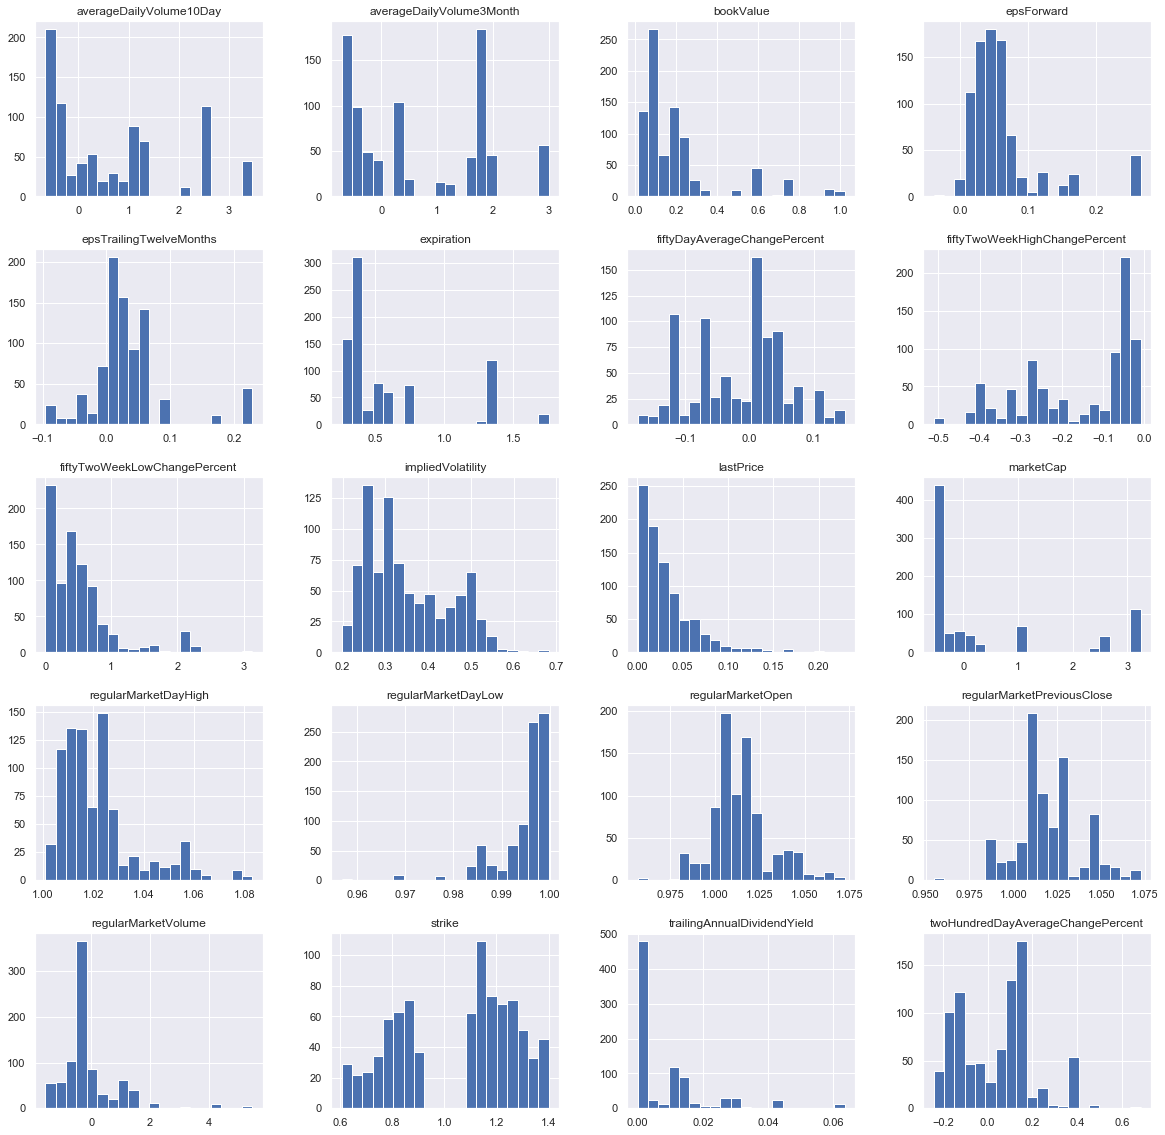

In [605]:
# plot histogram of feature distribution
visualize_ds(ml_all_df, 20, (20,20))

In [606]:
calls_df = all_df[all_df.type == 'call']
puts_df = all_df[all_df.type == 'put']
ml_all_df = prepare_for_training(all_df, to_keep, target_col)
ml_calls_df = prepare_for_training(calls_df, to_keep, target_col)
ml_puts_df = prepare_for_training(puts_df, to_keep, target_col)
# split into calls and puts
print('Total rows: {0}, {1} calls and {2} puts'.format(
    len(ml_all_df), len(ml_calls_df), len(ml_puts_df)))

Total rows: 6525, 3278 calls and 3247 puts


### Storage Steps

In [607]:
# store files locally or in cloud depending on configuration
%time store_file(ml_all_df, 'all')
%time store_file(ml_calls_df, 'call')
%time store_file(ml_puts_df, 'put')

train_df, test_df = shuffle_train_test(ml_all_df)
%time store_file(train_df, 'train', False)
%time store_file(test_df, 'test', False)
len(ml_all_df), len(ml_calls_df), len(ml_puts_df)
len(train_df), len(test_df)

Saved training/options_all.csv
CPU times: user 237 ms, sys: 82.2 ms, total: 319 ms
Wall time: 7.08 s
Saved training/options_call.csv
CPU times: user 105 ms, sys: 7.57 ms, total: 112 ms
Wall time: 907 ms
Saved training/options_put.csv
CPU times: user 104 ms, sys: 5.16 ms, total: 110 ms
Wall time: 785 ms
Saved training/options_train.csv
CPU times: user 150 ms, sys: 7.51 ms, total: 157 ms
Wall time: 793 ms
Saved training/options_test.csv
CPU times: user 56.4 ms, sys: 5.87 ms, total: 62.3 ms
Wall time: 376 ms


(4893, 1632)

### Training with local model

In [608]:
# Loads data from drive / S3
train_full_set = pd.read_csv('full_set.csv')
train_quote_frame = pd.read_csv('quote_frame.csv')
'{0} options'.format(train_full_set.underlyingSymbol.count()), \
'{0} quotes'.format(train_quote_frame.symbol.count())

('364999 options', '1170 quotes')

In [609]:
# transformation: turn dates > days > years
train_all_df = merge_ds(train_full_set, train_quote_frame)
print(len(train_all_df))
train_all_df = transform_ds(train_all_df)
print(len(train_all_df))
train_all_df = filter_ds(train_all_df)
print(len(train_all_df))
train_calls_df = train_all_df[train_all_df.type == 'call']
train_puts_df = train_all_df[train_all_df.type == 'put']
print('Total rows: {0}, {1} calls and {2} puts'.format(
    len(train_all_df), len(train_calls_df), len(train_puts_df)))

198513
198513
6525
Total rows: 6525, 3278 calls and 3247 puts


In [630]:
# CHANGE this line to select option type
OPTION_TYPE = 'call'

ml_df = (train_calls_df if OPTION_TYPE == 'call' else train_puts_df).copy()
ml_train_df = prepare_for_training(ml_df, to_keep, target_col)

X = ml_train_df.loc[:,ml_train_df.columns[:-1]].values
Y = ml_train_df.loc[:,target_col].values

# train_df, test_df = train_test_split(ml_df, random_state=1)
# print('{}, {}'.format(train_df.shape, test_df.shape))
# ml_train_df = prepare_for_training(train_df, to_keep, target_col)
# ml_test_df = prepare_for_training(test_df, to_keep, target_col)

In [621]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X, Y)
predictions = lin_reg.predict(X)
lin_mse = mean_squared_error(Y, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.011660948611483611

In [622]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, Y)
predictions = tree_reg.predict(X)
scores = cross_val_score(tree_reg, X, Y, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
scores, scores.mean(), scores.std()

(array([0.00730791, 0.00845641, 0.00858704, 0.00870922, 0.00641699,
        0.00544679, 0.00627983, 0.0071508 , 0.00643175, 0.00827985]),
 0.007306658418583729,
 0.001094091128091823)

In [623]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X, Y)

scores = cross_val_score(forest_reg, X, Y, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
scores, scores.mean(), scores.std()

(array([0.00622667, 0.00529888, 0.0065689 , 0.0059745 , 0.00506789,
        0.0046389 , 0.00465615, 0.00546644, 0.00497914, 0.00601549]),
 0.0054892957819087955,
 0.0006413661530488391)

In [624]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8] },
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2,3,4] }
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [627]:
grid_search.best_params_, grid_search.best_estimator_

({'max_features': 8, 'n_estimators': 30},
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))

In [628]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.017117785199874502 {'max_features': 2, 'n_estimators': 3}
0.01525901927102796 {'max_features': 2, 'n_estimators': 10}
0.013084486984094411 {'max_features': 2, 'n_estimators': 30}
0.013948142522956695 {'max_features': 4, 'n_estimators': 3}
0.010456532213795496 {'max_features': 4, 'n_estimators': 10}
0.008547605648102004 {'max_features': 4, 'n_estimators': 30}
0.01011640269538052 {'max_features': 6, 'n_estimators': 3}
0.007961586929199412 {'max_features': 6, 'n_estimators': 10}
0.006669400327372701 {'max_features': 6, 'n_estimators': 30}
0.00815591265352777 {'max_features': 8, 'n_estimators': 3}
0.0068003788255181375 {'max_features': 8, 'n_estimators': 10}
0.005821377661205383 {'max_features': 8, 'n_estimators': 30}
0.01563452757373293 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.013581673869902697 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.01460438926595981 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.010086489570644116 {'bootstrap': 

In [629]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, ml_train_df.columns[:-1]), reverse=True)

[(0.4558834187648738, 'expiration'),
 (0.2769383235348421, 'impliedVolatility'),
 (0.10730157758154243, 'strike'),
 (0.040736877004868235, 'trailingAnnualDividendYield'),
 (0.02382523608607216, 'fiftyTwoWeekHighChangePercent'),
 (0.01723087968403709, 'marketCap'),
 (0.011843380427682725, 'epsTrailingTwelveMonths'),
 (0.010215501320523086, 'averageDailyVolume3Month'),
 (0.009991077772444403, 'fiftyDayAverageChangePercent'),
 (0.009858588348010282, 'epsForward'),
 (0.008263599179389737, 'fiftyTwoWeekLowChangePercent'),
 (0.006356117267275339, 'regularMarketDayHigh'),
 (0.00435676081748819, 'averageDailyVolume10Day'),
 (0.004347870959707245, 'twoHundredDayAverageChangePercent'),
 (0.003164262278833679, 'bookValue'),
 (0.0030954012613916373, 'regularMarketDayLow'),
 (0.0025449926416483823, 'regularMarketVolume'),
 (0.0021467838289800207, 'regularMarketOpen'),
 (0.0018993512403894497, 'regularMarketPreviousClose')]

In [633]:
from sklearn.externals import joblib

fname = "{}_ML_model.pkl".format(OPTION_TYPE)
joblib.dump(grid_search.best_estimator_, fname)
print('Saved', fname)

Saved call_ML_model.pkl


Loaded call_ML_model.pkl
Predicted call RMSE 0.0019627836749356482


/Users/vveiga/miniconda3/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Figure size 3000x3000 with 0 Axes>

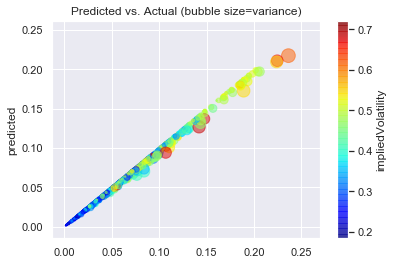

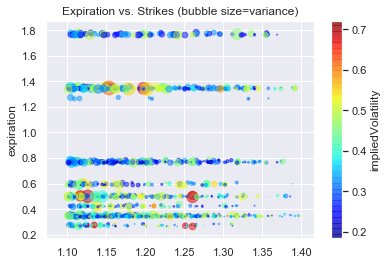

In [635]:
loaded_model = joblib.load(fname)
print('Loaded', fname)
res = loaded_model.predict(X)
print('Predicted {} RMSE {}'.format(option_type, np.sqrt(mean_squared_error(Y, res))))
plot_deltas(ml_df, res)

### Prediction Steps using AWS Model

In [ ]:
# load dataset from friday
# pre-process data
# keep a copy of row with all labels (dsA)
# produce an ML ready dataset (dsB)
# for each row in dsB run predict
# updated predicted column in dsA with ML output
# understand where the variance is (strike, expiration, or IV)
# ------
# write script to check batch prediction completion
# when finished load results from S3 and return results
# update prediction in original dataset
# run comparison to understand delta

In [ ]:
dates = read_dates()
predict_days = -1
predict_dates, train_dates = dates[predict_days:], dates[:predict_days]
train_dates, predict_dates

In [ ]:
# load contracts for predict date
%time full_set, quote_frame = load_option_files(predict_dates)

In [ ]:
# merge, filter and transform
all_df = merge_ds(full_set, quote_frame)
print(len(all_df))
all_df = transform_ds(all_df)
print(len(all_df))
all_df = filter_ds(all_df)
print(len(all_df))
# split by type
calls_df = all_df[all_df.type == 'call']
puts_df = all_df[all_df.type == 'put']
# process for ML
ml_all_df = prepare_for_training(all_df, to_keep, target_col)
ml_calls_df = prepare_for_training(calls_df, to_keep, target_col)
ml_puts_df = prepare_for_training(puts_df, to_keep, target_col)
# split into calls and puts
print_fmt = 'Total rows: {0}, {1} calls and {2} puts'
print(print_fmt.format(len(ml_all_df), len(ml_calls_df), len(ml_puts_df)))

In [ ]:
ml_model_id = 'ml-ro6h1x4MJIB'

pre_ml_df, ml_df = all_df.copy(), ml_all_df.copy()
size = len(ml_df)
pre_ml_df['predicted'] = -1
print(len(pre_ml_df), len(ml_df))

for x in ml_df.index:
    optn_row = ml_df.loc[x]
    record = optn_row[:-1].astype(np.str).to_dict()
    prediction = realtime_predict(ml_model_id, record)
    predVal = prediction['Prediction']['predictedValue']
    pre_ml_df.loc[x, 'predicted'] = predVal
    print_fmt = '{:.3f}, {:.3f}, {:.3f}'
    print(print_fmt.format(optn_row.lastPrice, predVal, predVal - optn_row.lastPrice))

In [ ]:
delta = abs((pre_ml_df['lastPrice'] - pre_ml_df['predicted']).round(3))
pre_ml_df.plot.scatter(x='lastPrice', y='predicted', s=delta*1000)

In [ ]:
pre_ml_df['delta'] = delta

In [ ]:
# delta ranking analysis
cols_show = ['strike', 'expiration', 'impliedVolatility', 'lastPrice', 'predicted', 'delta']
pre_ml_df[cols_show].sort_values(by='delta')

### Prediction using Local Model

In [101]:
# Date ranges for analysis
dates = read_dates()
predict_days = -1
predict_dates, train_dates = dates[predict_days:], dates[:predict_days]
train_dates, predict_dates

(['2018-09-07',
  '2018-09-10',
  '2018-09-11',
  '2018-09-12',
  '2018-09-13',
  '2018-09-14',
  '2018-09-17',
  '2018-09-18',
  '2018-09-19',
  '2018-09-20'],
 ['2018-09-21'])

In [102]:
# load contracts for predict date
# %time pred_full_set, pred_quote_frame = load_option_files(predict_dates)

pred_quote_frame = load_consol_quotes(predict_dates)
pred_full_set = load_consol_options(predict_dates)

# pred_full_set.to_csv('pred_full_set.csv', index=False)
# pred_quote_frame.to_csv('pred_quote_frame.csv', index=False)

Loading quotes for 2018-09-21
Loading options for 2018-09-21


In [103]:
# load the prediction date data
# pred_full_set = pd.read_csv('pred_full_set.csv')
# pred_quote_frame = pd.read_csv('pred_quote_frame.csv')
print('{0} options'.format(pred_full_set.underlyingSymbol.count()), \
'{0} quotes'.format(pred_quote_frame.symbol.count()))

rows_left = lambda x, y: print('{} left after {}'.format(len(x), y))
rows_left_by_type = lambda x, y, z: print('{}: {} calls, {} puts'.format(
    len(x), len(y), len(z)))

# merge, filter and transform
pred_all_df = merge_ds(pred_full_set, pred_quote_frame)
rows_left(pred_all_df, 'merge')
pred_all_df = transform_ds(pred_all_df)
rows_left(pred_all_df, 'transform')
pred_all_df = filter_ds(pred_all_df)
rows_left(pred_all_df, 'filter')
# split by type
pred_calls_df = pred_all_df[pred_all_df.type == 'call']
pred_puts_df = pred_all_df[pred_all_df.type == 'put']
# split into calls and puts
rows_left_by_type(pred_all_df, pred_calls_df, pred_puts_df)

97176 options 325 quotes
40230 left after merge
40230 left after transform
1427 left after filter
1427: 764 calls, 663 puts


In [77]:
# prediction and analysis functions
def update_deltas(ml_df, predictions, pred_col, var_col):
    post_pred_df = ml_df.copy()
    post_pred_df.loc[:,pred_col] = predictions
    post_pred_df.loc[:,var_col] = post_pred_df[pred_col] - post_pred_df.lastPrice
    return post_pred_df

def plot_deltas(post_pred_df, pred_col, var_col):
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax1 = post_pred_df.plot.scatter(x='lastPrice', y=pred_col, 
        s=post_pred_df[var_col]*10**4, alpha=0.5, c='impliedVolatility', 
        cmap=plt.get_cmap('jet'),
        title='Predicted vs. Actual (bubble size=variance)')
    plt.setp(ax1.get_xticklabels(), visible=True)
    ax1.set_xlim(0,.15)
    ax1.set_ylim(0,.15)
    ax2 = post_pred_df.plot.scatter(
        x='strike', y='expiration', s=post_pred_df[var_col]*10**4, alpha=0.5, 
        c='impliedVolatility', cmap=plt.get_cmap('jet'),
        title='Expiration vs. Strikes (bubble size=variance)', sharex=ax1)
    plt.setp(ax2.get_xticklabels(), visible=True)
    plt.setp(ax2.get_xticklabels(), visible=True)
    plt.show()

In [92]:
# compare and visualize
OPTION_TYPE = 'call'
ml_df = (pred_calls_df if OPTION_TYPE == 'call' else pred_puts_df).copy()
ml_train_df = prepare_for_training(ml_df, to_keep, target_col)

X = ml_train_df.loc[:,ml_train_df.columns[:-1]].values
Y = ml_train_df.loc[:,target_col].values

fname = "{}_ML_model.pkl".format(OPTION_TYPE)
loaded_model = joblib.load(fname)

res = loaded_model.predict(X)
print('Predicted {} RMSE {}'.format(OPTION_TYPE, np.sqrt(mean_squared_error(Y, res))))

PREDICTION_COL = 'prediction'
DELTA_COL = 'predictionDelta'
post_pred_df = update_deltas(ml_df, res, PREDICTION_COL, DELTA_COL)
# plot_deltas(post_pred_df, PREDICTION_COL, DELTA_COL)

Predicted call RMSE 0.0166739228495018


In [93]:
ANALYSIS_COLS = ['contractSymbol', 'type' ,'underlyingSymbol',
                 'impliedVolatility', 'expiration', 'strike','lastPrice', 
                 'prediction', 'predictionDelta']
post_pred_df[ANALYSIS_COLS].sort_values(by='predictionDelta', ascending=True).tail(5).round(3)

,contractSymbol,type,underlyingSymbol,impliedVolatility,expiration,strike,lastPrice,prediction,predictionDelta
4375,CI200117C00260000,call,CI,0.262,1.323,1.291,0.032,0.054,0.022
28739,ATHN200117C00160000,call,ATHN,0.252,1.323,1.154,0.050,0.073,0.023
38376,UPS200117C00135000,call,UPS,0.181,1.323,1.133,0.034,0.060,0.026
35576,SAND200117C00005000,call,SAND,0.490,1.323,1.306,0.104,0.142,0.037
19581,NWSA190418C00014000,call,NWSA,0.792,0.573,1.109,0.044,0.102,0.059


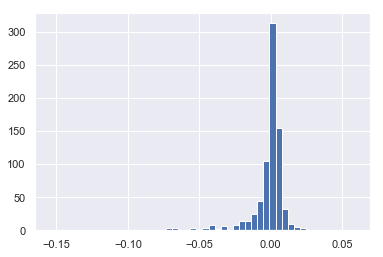

In [94]:
post_pred_df.predictionDelta.hist(bins=50)

In [95]:
# pred_all_df[pred_all_df.contractSymbol == 'CMG190118P00300000'].T

In [96]:
print('Ranks by annualized return')
pricingCols = ['lastPrice','prediction','predictionDelta']
post_pred_df[pricingCols] = (post_pred_df[pricingCols].T * pred_all_df.loc[post_pred_df.index].regularMarketPrice).T.round(2)
ranked_ann = ((post_pred_df[DELTA_COL] / post_pred_df.lastPrice) \
              / (post_pred_df.strike / post_pred_df.expiration) * 100).sort_values(ascending=False)
ANN_RET = 'annReturn'
post_pred_df[ANN_RET] = ranked_ann.round(1)
ANALYSIS_COLS.extend([ANN_RET])
final = post_pred_df[ANALYSIS_COLS].sort_values(by=ANN_RET, ascending=False).head(10)
fname = '{}-option-{}.csv'.format(OPTION_TYPE, str(date.today()))
final.to_csv(fname, index=False)

Ranks by annualized return


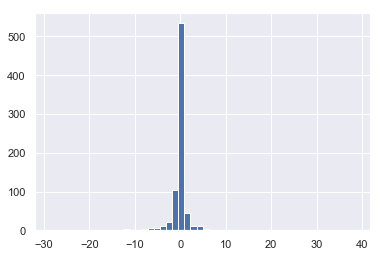

In [97]:
post_pred_df.predictionDelta.hist(bins=50)

In [98]:
post_pred_df[(post_pred_df.annReturn > 15)].annReturn.value_counts(bins=10)

(15.0, 24.97]      61
(24.97, 34.84]     17
(34.84, 44.71]     13
(44.71, 54.58]      7
(64.45, 74.32]      5
(74.32, 84.19]      2
(103.93, 113.8]     1
(84.19, 94.06]      1
(94.06, 103.93]     0
(54.58, 64.45]      0
Name: annReturn, dtype: int64

### Visualization Explorations

In [9]:
all_df = merge_ds(full_set, quote_frame)
test_df = all_df.copy()
test_df = test_df[test_df.inTheMoney == False]
print(len(test_df))

NameError: name 'full_set' is not defined

In [ ]:
# what's the distribution of strike prices?
strikes = (test_df.strike / test_df.regularMarketPrice).round(2)
viz_bins = strikes.value_counts(bins=12).sort_index()
(viz_bins / viz_bins.sum()).plot.bar()

In [ ]:
print(len(test_df))
test_df.strike = (test_df.strike / test_df.regularMarketPrice).round(2)
test_df.expiration = (pd.to_datetime(all_df.expiration) - pd.to_datetime(all_df.storeDate)).dt.days
test_df.lastPrice = (all_df.lastPrice / all_df.regularMarketPrice)
test_df.impliedVolatility = test_df.impliedVolatility.round(2)

In [ ]:
test_df.expiration.value_counts().sort_index(ascending=False).head(40).tail(5)
# test_df.expiration.hist(bins=50, cumulative=True)

In [ ]:
test_df = test_df[test_df.expiration > 125]
print(len(test_df))

In [ ]:
mask = ((test_df.strike > 0.6) & (test_df.strike < 0.9)) | ((test_df.strike > 1.1) & (test_df.strike < 1.4))
test_df = test_df[mask]
print(len(test_df))
test_df.strike.value_counts().sort_values().head(40).tail(5)

In [ ]:
# test_df[(test_df.openInterest > 50) & (test_df.openInterest < 1*10**3)].openInterest.value_counts(bins=50).sort_index()
test_df[(test_df.openInterest > 50) & (test_df.openInterest < 1*10**3)].openInterest.hist(bins=10)

In [ ]:
test_df = test_df[(test_df.volume > 10) & (test_df.openInterest > 20)]
print(len(test_df))

In [ ]:
test_df.marketCap = (test_df.marketCap / 10**9).round(0)

In [ ]:
test_df.groupby(by=['strike','expiration'], sort=True).lastPrice.count().sort_values(ascending=False)

In [ ]:
# test_df = test_df[(test_df.expiration == 126) & (test_df.strike == 1.11)]
# cols_to_show = ['symbol','strike','expiration','marketCap','impliedVolatility','lastPrice']
# chart_df = test_df[cols_to_show].sort_values(by='marketCap')
# chart_df

# chart_df.plot.scatter(x='lastPrice', y='impliedVolatility')
# chart_df.plot.scatter(x='marketCap', y='impliedVolatility')
# chart_df = test_df.groupby(['expiration','strike'])
# chart_df.impliedVolatility.count().sort_values(ascending=False)
# test_df.groupby(['symbol']).impliedVolatility.sum().sort_values(ascending=False)
# print(len(test_df))
chart_df = test_df.groupby(['expiration','strike']).impliedVolatility.mean().sort_values(ascending=False)
# check_cols = ['symbol','expiration','strike','storeDate','impliedVolatility','contractSymbol']
# test_df[['symbol','impliedVolatility']].sort_values(by='impliedVolatility')
# test_df.impliedVolatility.round(2)
# filter_df = test_df[(test_df.expiration == 129) & (test_df.strike == 0.8)]
# filter_df.symbol.unique()
# contracts = filter_df[filter_df.symbol == 'AAPL'].contractSymbol
# full_set[full_set.contractSymbol.isin([contracts.values[1]])]
# chart_df = chart_df.to_frame().unstack()
# fig, ax = plt.subplots()
# fig.set_figwidth(20)
# fig.set_figheight(20)
# ax.xaxis.set_label(chart_df.columns)
# ax.yaxis.set_label(chart_df.index)
# ax.imshow(chart_df, interpolation='nearest')